In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import glob
from scipy.optimize import minimize
from scipy.interpolate import interp2d
import skimage.exposure as skie
from pylab import figure, cm
from matplotlib.colors import LogNorm
import img_scale

In [52]:
def mk_master_by_median(list_of_imgs, plot_q=False):
    
    list_of_imgs = [os.path.join(img_dir, fn) for fn in list_of_imgs]
    
    # Load the images
    imgs = []
    for fn in list_of_imgs:
        
        print('Loading', fn)
        
        imgs.append(fits.getdata(fn))
        
    print(np.shape(np.stack(imgs, axis=2)))
    
    # Calculate the meadian of the images
    mstr_img = np.nanmedian(np.stack(imgs, axis=2), axis=2)
    
    if plot_q:
        # Plot the median image
        plt.figure()
        plt.imshow(mstr_img, cmap='gray')
    
    return mstr_img


def plt_v1(img0, t1, t2, cmap='gray', rescale_img_q=False):
    
    avg = str(np.around(np.nanmean(img0), 2))
    sd = str(np.around(np.nanstd(img0), 2))
    
    if rescale_img_q:
        img = rescale_img(np.copy(img0))
    else:
        img = img0
    
    # Show the full image
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap=cmap, origin='bottom')
    plt.title(t1 + '  |  avg=' + avg + '  |  SD=' + sd)

    # Show a small section of the image
    plt.subplot(1,2,2)
    plt.imshow(img[200:250, 500:550], cmap=cmap, origin='bottom')
    plt.title(t2)
    
    
def plt_input_imgs(list_of_imgs0, cmap='gray', rescale_img_q=False):
    
    
    list_of_imgs = [os.path.join(img_dir, fn) for fn in list_of_imgs0]
    
    # Load the images
    imgs = []
    for fn in list_of_imgs:
        
        print('Loading', fn)
        
        imgs.append(fits.getdata(fn))
    
    
    # Plot the images in a grid
    from mpl_toolkits.axes_grid1 import ImageGrid
    
    n = np.int32(np.ceil(np.sqrt(len(imgs))))
    
    fig = plt.figure(figsize=(15,10))
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n, n),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    i = 0
    for ax, im in zip(grid, imgs):
        
        # Iterating over the grid returns the Axes.
        ax.imshow(rescale_img(im), cmap=cmap, origin='bottom')
        ax.set_title(list_of_imgs0[i])
        i+=1

    plt.show()
    
    
def plt_input_imgs2(imgs, list_of_imgs0, cmap='gray', rescale_img_q=False):
    
    # Plot the images in a grid
    from mpl_toolkits.axes_grid1 import ImageGrid
    
    n = np.int32(np.ceil(np.sqrt(len(imgs))))
    
    fig = plt.figure(figsize=(15,10))
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n, n),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    i = 0
    for ax, im in zip(grid, imgs):
        
        # Iterating over the grid returns the Axes.
        ax.imshow(rescale_img(im), cmap=cmap, origin='bottom')
        ax.set_title(list_of_imgs0[i])
        i+=1

    plt.show()
    
    
def rescale_img(img):
    
    import skimage.exposure as skie

    low = np.percentile(img, 0.25)
    high = np.percentile(img, 99.5)
    
    return skie.exposure.rescale_intensity(img, in_range=(low, high))

In [5]:
def minfun(dxy, x, y, i_obs, itmp_pp, var_scalers):

    itmp_xdc = itmp_pp(x + dxy[0] / var_scalers[0], y + dxy[1] / var_scalers[1])
    
    #print('inminfun', x[0], x[-1], y[0], y[-1])
    #print('inminfun', x[0] + dxy[0] / var_scalers[0], x[-1] + dxy[0] / var_scalers[0], y[0] + dxy[1] / var_scalers[1], y[-1] + dxy[1] / var_scalers[1])
    #print('dx, dy', dxy[0] / var_scalers[0], dxy[1] / var_scalers[1])
    #print('x', np.min(x + dxy[0] / var_scalers[0]), np.max(x + dxy[0] / var_scalers[0]))
    #print('y', np.min(y + dxy[1] / var_scalers[1]), np.max(y + dxy[1] / var_scalers[1]))
    
    return np.sum( (i_obs - itmp_xdc)**2 * np.abs(i_obs))


def img_align0(i_stat, i_mov, sv=np.array([0,0]), max_shift=5, cut_px=7, vs=1e-1):
    
    #cut_px = cut_px + np.int32(np.ceil(np.max(np.abs(sv))))
    
    x, y = np.arange(np.shape(i_mov)[1]), np.arange(np.shape(i_mov)[0])
    
    i_mov_pp = interp2d(x, y, i_mov, kind='cubic', fill_value=np.nan)
    
    var_scalers = np.array([vs, vs])

    x0 = sv * var_scalers
    
    xc = x + sv[0]
    xc = x[(xc + 1 < len(x)) & (xc - 1 > 0)]
    
    yc = y + sv[1]
    yc = y[(yc + 1 < len(y)) & (yc - 1 > 0)]
    
    print('xc', xc[0], xc[-1])
    print('yc', yc[0], yc[-1])

    p3 = minimize(minfun, x0, 
                  method='L-BFGS-B', 
                  bounds=[[-max_shift * var_scalers[0] + x0[0], max_shift * var_scalers[0] + x0[0]], 
                          [-max_shift * var_scalers[1] + x0[1], max_shift * var_scalers[1] + x0[1]]
                         ], 
                  args=(xc, 
                        yc, 
                        i_stat[yc,:][:, xc], 
                        i_mov_pp, 
                        var_scalers
                       ),
                  options={'maxfun': 15000, 'maxiter': 15000})
    
    i_mov_new = i_mov_pp(x + p3.x[0] / var_scalers[0], y + p3.x[1] / var_scalers[1])
    
    return i_mov_new, p3.x[0] / var_scalers[0], p3.x[1] / var_scalers[1], p3



def img_align_mini(i_stat, i_mov_pp, x, y, sv=np.array([0,0]), max_shift=5, cut_px=7, vs=1e-2):
    
    cut_px = cut_px + np.int32(np.ceil(np.max(np.abs(sv))))
    
    var_scalers = np.array([vs, vs])

    x0 = sv * var_scalers
    
    xc = x + sv[0]
    xc = x[(xc + max_shift < len(x)) & (xc - max_shift > 0)]
    xc = xc[1:-1]
    
    yc = y + sv[1]
    yc = y[(yc + max_shift < len(y)) & (yc - max_shift > 0)]
    yc = yc[1:-1]
    
    #print('b4min xc', xc[0], xc[-1])
    #print('b4min yc', yc[0], yc[-1])

    p3 = minimize(minfun, x0, 
                  method='L-BFGS-B', 
                  bounds=[[-max_shift * var_scalers[0] + x0[0], max_shift * var_scalers[0] + x0[0]], 
                          [-max_shift * var_scalers[1] + x0[1], max_shift * var_scalers[1] + x0[1]]
                         ], 
                  args=(xc, 
                        yc, 
                        i_stat[yc,:][:, xc], 
                        i_mov_pp, 
                        var_scalers
                       ),
                  options={'maxfun': 15000, 'maxiter': 15000})
    
    i_mov_new = i_mov_pp(x + p3.x[0] / var_scalers[0], y + p3.x[1] / var_scalers[1])
    
    return i_mov_new, p3.x[0] / var_scalers[0], p3.x[1] / var_scalers[1], p3


def find_integer_shift(i_stat, i_mov, max_shift, step, row_col_skip=3):
    
    i_stat2 = i_stat[::row_col_skip, ::row_col_skip]
    i_mov2 = i_mov[::row_col_skip, ::row_col_skip]
    
    dxs = []
    dys = []
    lsq = []

    dxa = np.arange(-max_shift, max_shift+1, step, dtype=int)
    dya = np.arange(-max_shift, max_shift+1, step, dtype=int)
        
    for dx in dxa:

        for dy in dya:

            i_mov_cut = np.roll(np.roll(i_mov2, dy, axis=0), dx, axis=1)

            #lsq.append( np.nansum( (i_stat - i_mov_cut)**2 * np.abs(i_stat) ) )
            lsq.append( np.sum( np.abs(i_stat2 - i_mov_cut) ) )
            dxs.append(dx)
            dys.append(dy)
            
    bv = np.argmin(lsq)
    dx = dxs[bv]
    dy = dys[bv]
    
    return -dx*row_col_skip, -dy*row_col_skip


def img_align2(i_stat, i_mov, max_shift=5, cut_px=7, vs=1.0):
    
    row_col_skip = 3
    
    dx, dy = find_integer_shift(i_stat, i_mov, max_shift=np.int32(max_shift / row_col_skip)+1, 
                                step=3, 
                                row_col_skip=row_col_skip)
    
    print('s1:', dx, dy)
    
    if max_shift > cut_px + 2:
        
        cut_px = max_shift + 2 
    
    x, y = np.arange(np.shape(i_mov)[1]), np.arange(np.shape(i_mov)[0])
    
    i_mov_pp = interp2d(x, y, i_mov, kind='cubic', fill_value=np.nan)
    
    i_mov_new, dx, dy, res = img_align_mini(i_stat, i_mov_pp, x, y, 
                                           sv=np.array([dx, dy]), 
                                           max_shift=10, 
                                           cut_px=11, 
                                           vs=vs)
    
    print('s2:', dx, dy)
    
    #print(res)
    
    return i_mov_new, dx, dy


def img_align(i_stat, i_mov, max_shift=5, cut_px=7, acc_px=1):
    
    if max_shift > cut_px + 2:
        
        cut_px = max_shift + 2 
    
    x, y = np.arange(np.shape(i_mov)[1]), np.arange(np.shape(i_mov)[0])
    
    i_mov_pp = interp2d(x, y, i_mov, kind='linear', fill_value=np.nan)
    
    
    xc = x[cut_px:-cut_px]
    yc = y[cut_px:-cut_px]
    i_stat_cut = i_stat[cut_px:-cut_px, cut_px:-cut_px]
    step = np.ceil( max_shift * 2 / 5)
    it = 0
    
    while step > acc_px:
        
        step = step / 2
        
        dxs = []
        dys = []
        lsq = []
    
        if it == 0:
            dxa = np.arange(-max_shift, max_shift+1, step)
            dya = np.arange(-max_shift, max_shift+1, step)
        else:
            dxa = np.arange(dx - step * 2, dx + step * 2, step)
            dya = np.arange(dy - step * 2, dy + step * 2, step)
            
            #print(dxa)
            #print(dx - step * 2, dx + step * 2, step)
            
            #print(dya)
            #print(dy - step * 2, dy + step * 2, step)
            
        for dx in dxa:

            for dy in dya:
                
                #print(dx, dy)

                i_mov_cut = i_mov_pp(xc + dx, yc + dy)

                lsq.append( np.nansum( np.abs(i_stat_cut - i_mov_cut) ) )
                dxs.append(dx)
                dys.append(dy)

        #print(lsq)
        bv = np.argmin(lsq)
        dx = dxs[bv]
        dy = dys[bv]
        
        it+=1
        
        #print(it, bv, len(dxa)*len(dya), step)
    
    print('Finished lsq solver. dx, dy =', dx, dy)
    
    #i_mov_new = i_mov_pp(x + dx, y + dy)
    
    i_mov_new, dx, dy = img_align_mini(i_stat, i_mov_pp, x, y, 
                                       sv=np.array([dx, dy]), 
                                       max_shift=2, 
                                       cut_px=4, 
                                       vs=1e-2)
    
    return i_mov_new, dx, dy


def rs2(fimg2, mc, lb, ub):
    
    # Normalize
    image_gray = fimg2[:,:,mc]# / np.nanmax(fimg2[:,:,mc])

    image_gray[np.isnan(image_gray)] = 0.0

    # Similar to a log normalization. Decrease flux gradiants
    limg = np.arcsinh(image_gray)
    limg = limg / np.nanmax(limg)

    low = np.percentile(limg, lb)
    high = np.percentile(limg, ub)
    
    fimgrs = np.copy(fimg2)
    
    for i in range(3):
        limg = np.arcsinh(image_gray)
        limg = limg / np.nanmax(limg)
        
        fimgrs[:,:,i] = skie.exposure.rescale_intensity(limg, in_range=(low, high))
        
    return fimgrs


def rs(fimg2, lb, ub):
    
    # Normalize
    image_gray = fimg2 / np.nanmax(fimg2)

    image_gray[np.isnan(image_gray)] = 0.0

    # Similar to a log normalization. Decrease flux gradiants
    limg = np.arcsinh(image_gray)
    limg = limg / np.nanmax(limg)

    low = np.percentile(limg, lb)
    high = np.percentile(limg, ub)
    return skie.exposure.rescale_intensity(limg, in_range=(low, high))


    
    
def combo_cc(r0, g0, b0):

    # Combine the color channels

    pix2rbg = 1 / 65536

    img = np.zeros((np.shape(r0)[0], np.shape(r0)[1], 3))

    for i, d in enumerate([np.copy(r0), np.copy(g0), np.copy(b0)]):

        d = d * pix2rbg

        img[:,:,i] = d

    return img / np.nanmax(img)# * 255


def normScale(input0, min0, max0):
    
    if np.size(input0, 0) == 0 or np.size(input0, 1) == 0:
        
        output0 = ( input0 - np.nanmin(input0) ) * ( max0 - min0 ) / ( np.nanmax(input0) - np.nanmin(input0) ) + min0
        
    else:
        
        minUni = np.nanmin(input0)
        maxUni = np.nanmax(input0)
        
        output0 = ( input0 - minUni ) * ( max0 - min0 ) / ( maxUni - minUni ) + min0
    
    return output0

# Images Directory

In [6]:
# Where are all of the images located (full path)
# img_dir = r'C:\Users\Kevin\Group7'
img_dir = r'C:\Users\claire\Documents\_ research _\notebooks\Group7'

# Master Dark

## Check input images for major defects

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s010.FIT


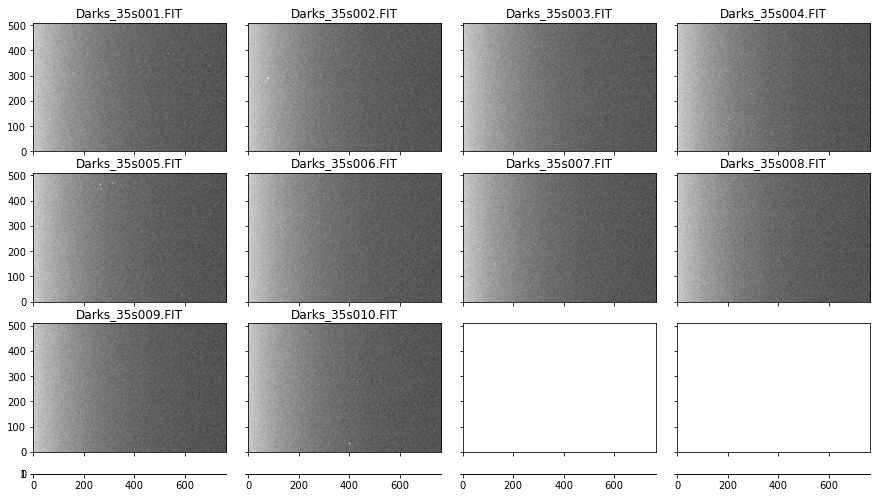

In [28]:
# Find all images to stack
list_of_darks = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, 'Darks_35s*.FIT'))]

# Plot the images that will be stacked
plt_input_imgs(list_of_darks, cmap='gray', rescale_img_q=True)

## Calculate median of the images

In [29]:
# Make the master image
mast_dark = mk_master_by_median(list_of_darks, plot_q=False)

dark_exptime = np.float64(fits.getheader(os.path.join(img_dir, list_of_darks[0]))['EXPTIME'])

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Darks_35s010.FIT
(510, 765, 10)


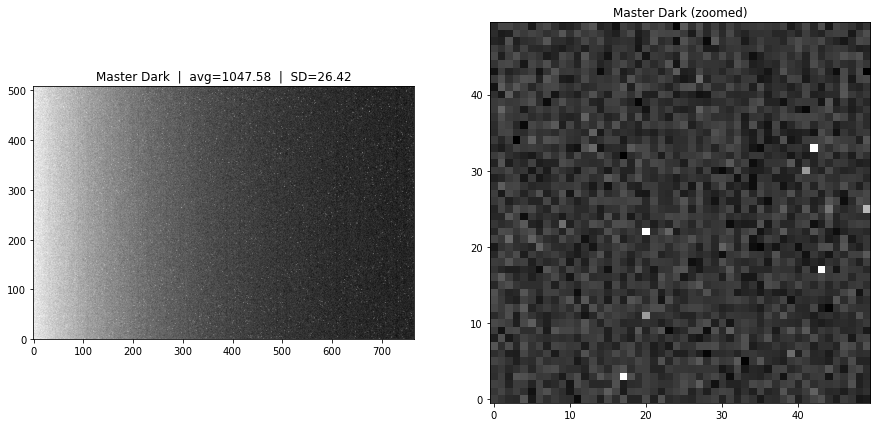

In [30]:
# Plot the median image
plt_v1(mast_dark, 
       t1='Master Dark', 
       t2='Master Dark (zoomed)', 
       cmap='gray', 
       rescale_img_q=True)

# Master Bias

## Check input images for major defects

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s010.FIT


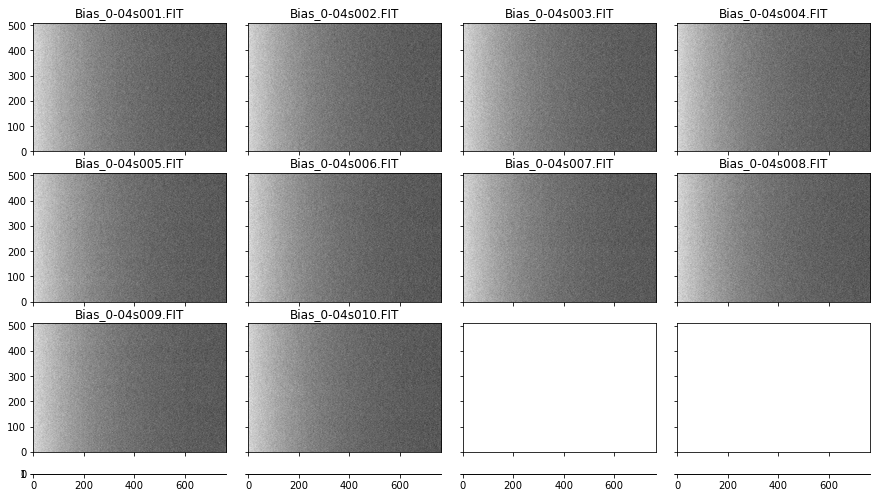

In [31]:
# Find all images to stack
list_of_biases = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, 'Bias*.FIT'))]

# Plot the images that will be stacked
plt_input_imgs(list_of_biases, cmap='gray', rescale_img_q=True)

## Calculate median of the images

In [32]:
# Make the master image
mast_bias = mk_master_by_median(list_of_biases, plot_q=False)

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Bias_0-04s010.FIT
(510, 765, 10)


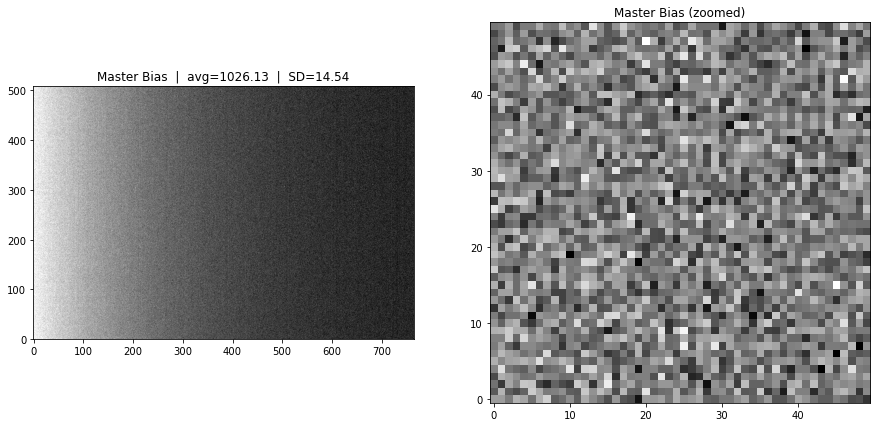

In [34]:
# Plot the median image

plt_v1(mast_bias, 
       t1='Master Bias', 
       t2='Master Bias (zoomed)', 
       cmap='gray', 
       rescale_img_q=True)

# Master Flat

## Check input images for major defects

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0001.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0002.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0003.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0004.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0005.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0006.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0007.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0008.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0009.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0010.2s.FIT


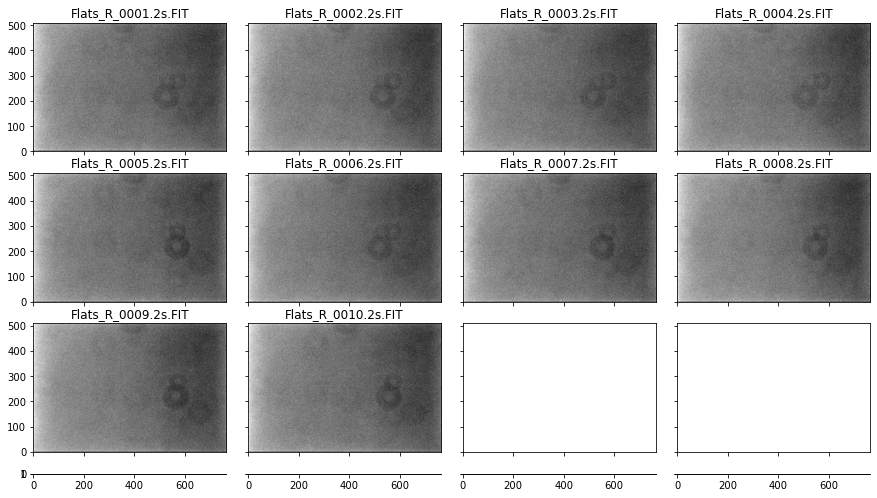

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3010.FIT


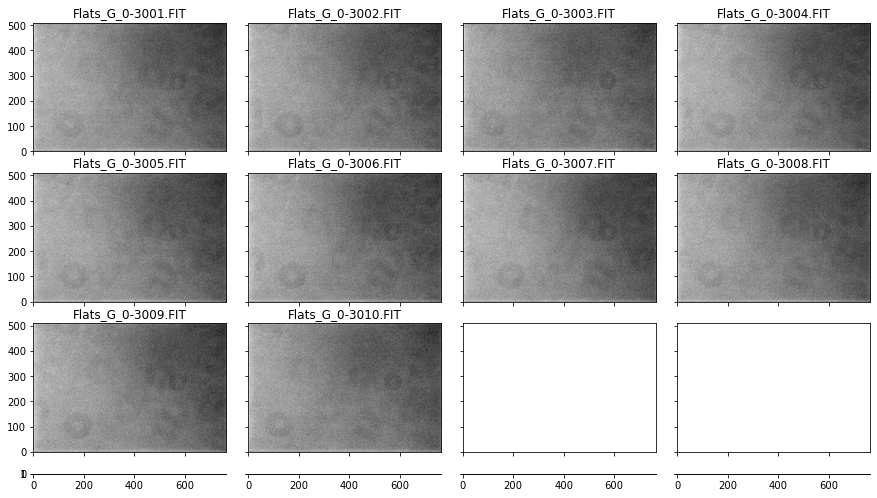

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_B_2-5010.FIT


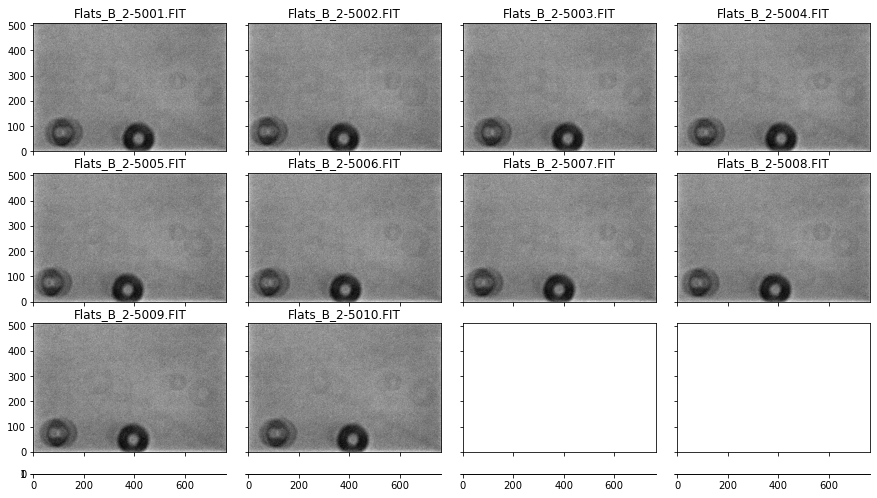

In [35]:
# Find all images to stack
# Red
list_of_flats_r = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, 'Flats_R*.FIT'))]


# Green
list_of_flats_g = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, 'Flats_G*.FIT'))]

# Blue
list_of_flats_b = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, 'Flats_B*.FIT'))]

# Plot the images that will be stacked
for list_of_imgs, cstr in zip([list_of_flats_r, list_of_flats_g, list_of_flats_b], ['Red', 'Green', 'Blue']):
    
    plt_input_imgs(list_of_imgs, cmap='gray', rescale_img_q=True)

## Calculate median of the images

In [17]:
# Make the master images
mast_flat_r = mk_master_by_median(list_of_flats_r, plot_q=False)

mast_flat_g = mk_master_by_median(list_of_flats_g, plot_q=False)

mast_flat_b = mk_master_by_median(list_of_flats_b, plot_q=False)

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0001.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0002.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0003.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0004.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0005.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0006.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0007.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0008.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0009.2s.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_R_0010.2s.FIT
(510, 765, 10)
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\Flats_G_0-3001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group

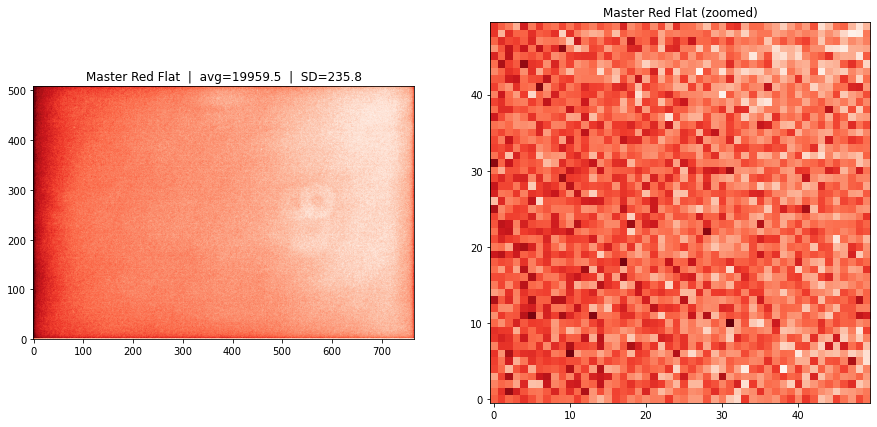

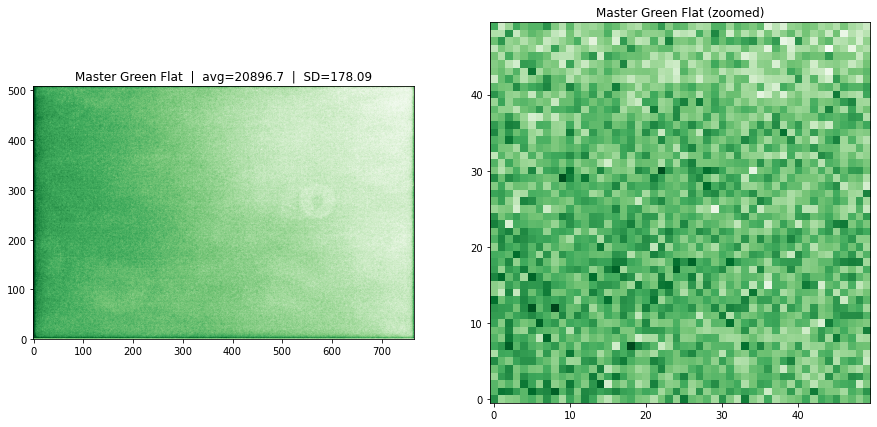

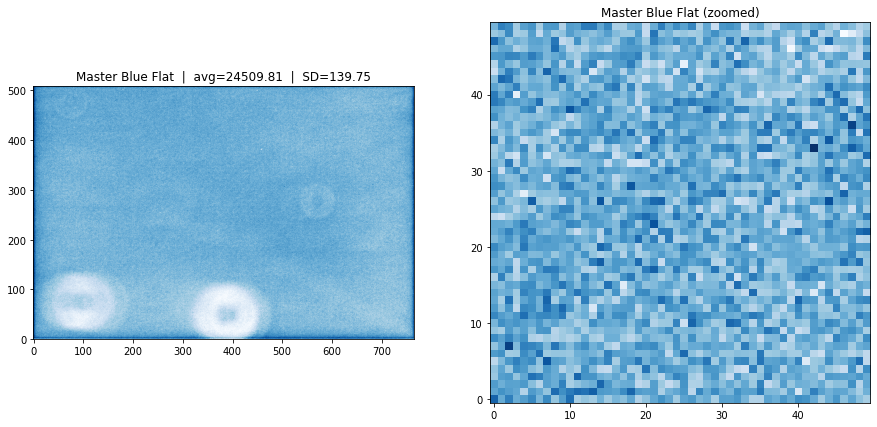

In [19]:
# Plot the median images

for im, cstr in zip([mast_flat_r, mast_flat_g, mast_flat_b], ['Red', 'Green', 'Blue']):
    
    plt_v1(im, 
           t1='Master ' + cstr + ' Flat', 
           t2='Master ' + cstr + ' Flat (zoomed)', 
           cmap=cstr + 's', 
           rescale_img_q=True)

# Science image calibration

In [36]:
def calib(list_of_imgs0, dark0, bias, flat0, dark_exptime, plot_q=False):
    
    flat = flat0 - bias
    flat = np.nanmean(flat) / flat
    dark = dark0 - bias
    
    
    list_of_imgs = [os.path.join(img_dir, fn) for fn in list_of_imgs0]
    
    # Load the images
    imgs = []
    for fn in list_of_imgs:
        
        #print('Loading', fn)
        
        img = fits.getdata(fn) - bias
        
        img_exptime = np.float64(fits.getheader(fn)['EXPTIME'])
        
        img = (img / img_exptime - dark / dark_exptime) / flat
        
        #img = img - np.min(img)
        
        imgs.append( img )
        
    
    return imgs

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s010.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s011.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_R_35s012.FIT
Loading C:\Users\claire\Docu

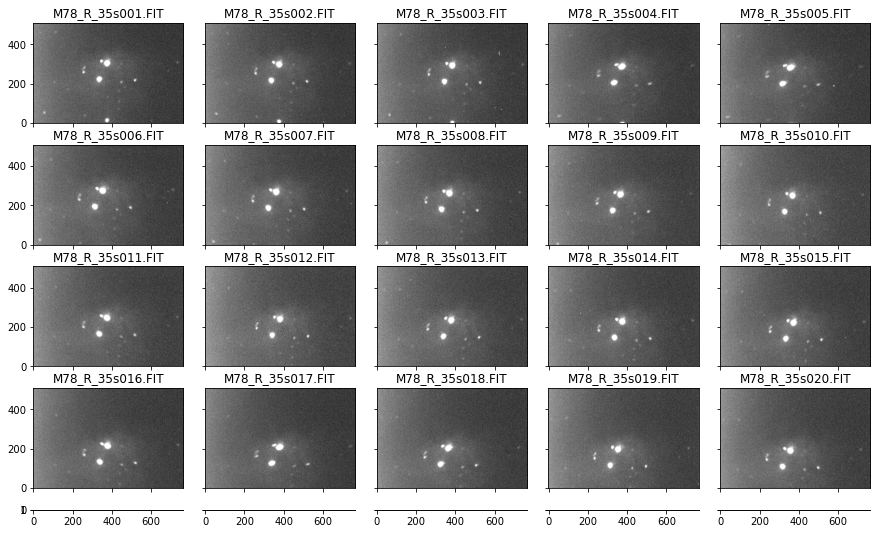

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s010.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s011.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_G_35s012.FIT
Loading C:\Users\claire\Docu

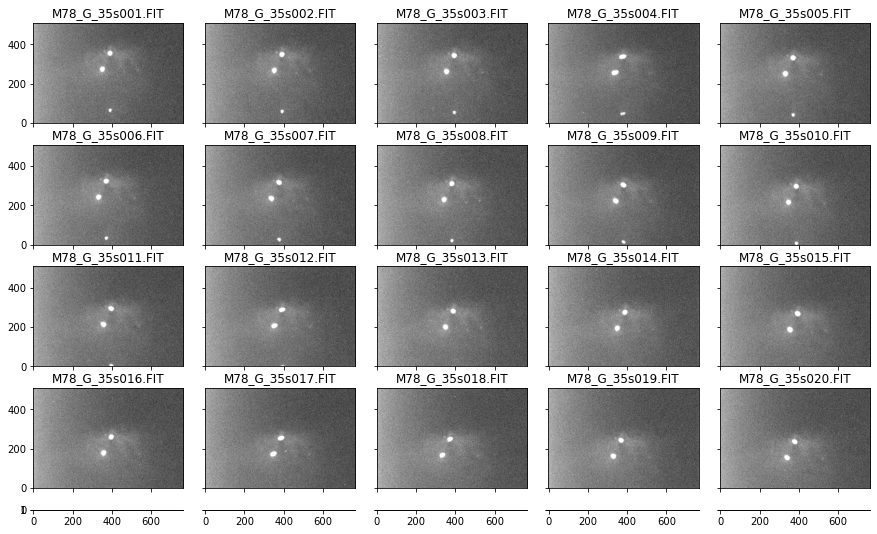

Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s001.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s002.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s003.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s004.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s005.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s006.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s007.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s008.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s009.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s010.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s011.FIT
Loading C:\Users\claire\Documents\_ research _\notebooks\Group7\M78_B_35s012.FIT
Loading C:\Users\claire\Docu

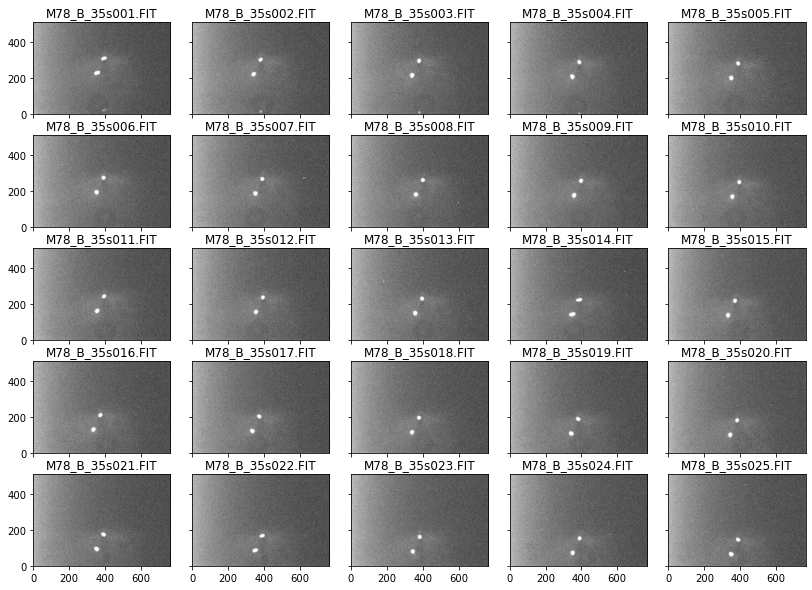

In [37]:
obj_name = 'M78'
#obj_name = 'West'
#obj_name = 'Zenith'
#obj_name = 'HD47240'

# Find all images to stack
# Red
list_of_sci_r = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, obj_name + '*_R*.FIT'))]
# Green
list_of_sci_g = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, obj_name + '*_G*.FIT'))]
# Blue
list_of_sci_b = [i.replace(img_dir + '\\', '') for i in glob.glob(os.path.join(img_dir, obj_name + '*_B*.FIT'))]

# Plot the images that will be stacked
if 1:
    for list_of_imgs, cstr in zip([list_of_sci_r, list_of_sci_g, list_of_sci_b], ['Red', 'Green', 'Blue']):

        plt_input_imgs(list_of_imgs, cmap='gray', rescale_img_q=0)

In [38]:
mast_sci_r_all = calib(list_of_sci_r, mast_dark, mast_bias, mast_flat_r, dark_exptime, plot_q=False)

mast_sci_g_all = calib(list_of_sci_g, mast_dark, mast_bias, mast_flat_g, dark_exptime, plot_q=False)

mast_sci_b_all = calib(list_of_sci_b, mast_dark, mast_bias, mast_flat_b, dark_exptime, plot_q=False)

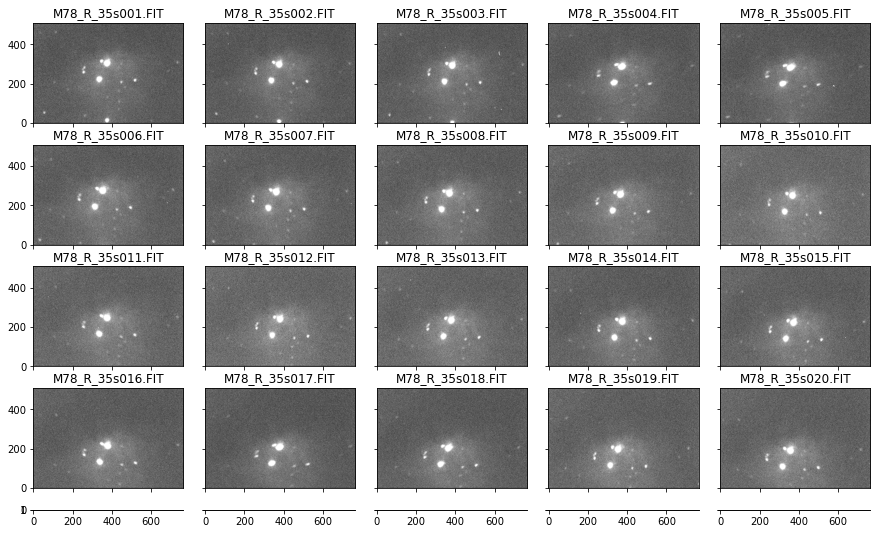

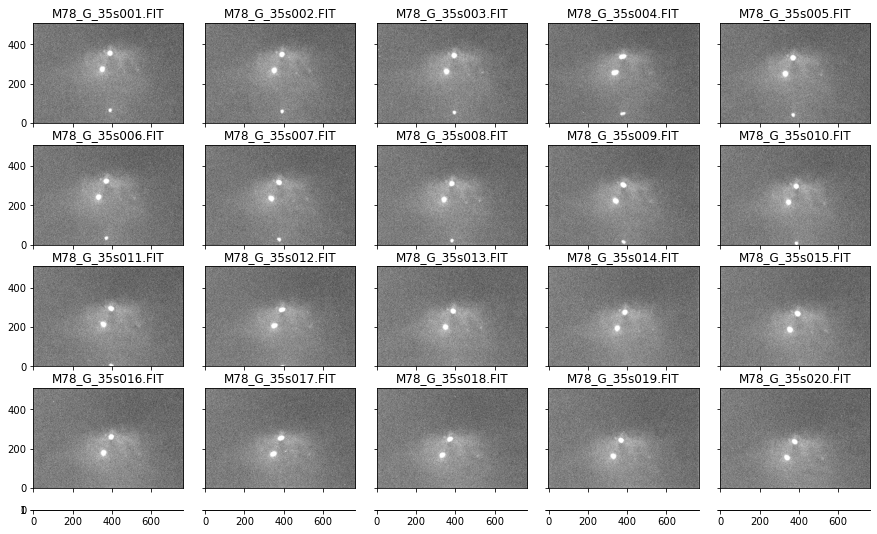

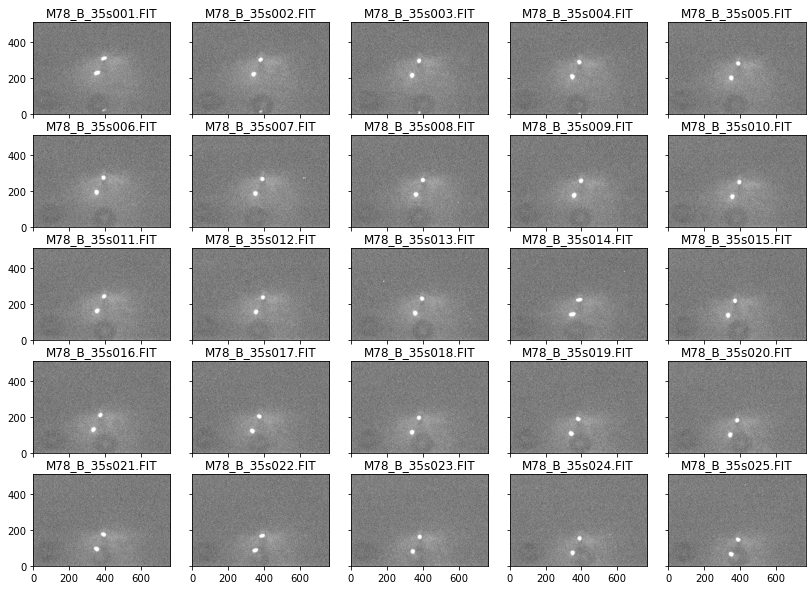

In [41]:
if 1:
    for list_of_imgs, cstr, imgs in zip([list_of_sci_r, list_of_sci_g, list_of_sci_b], 
                                        ['Red', 'Green', 'Blue'], 
                                        [mast_sci_r_all, mast_sci_g_all, mast_sci_b_all]):

        plt_input_imgs2(imgs, list_of_imgs, cmap='gray', rescale_img_q=0)

# Align science images

In [42]:
def align_two_imgs(img1, img2):
    
    # Align two images using the astropy method (fast & accurate)
    
    from skimage.feature import register_translation
    import scipy.ndimage as ndimage
    
    shift, error, diffphase = register_translation(img1, img2, upsample_factor=100)

    dx = shift[1]
    dy = shift[0]

    img2_shifted = ndimage.shift(img2, shift)
        
    return img2_shifted, dx, dy


def align_imgs(imgs):
    
    # Align a list of images using the astropy method (fast & accurate)
    
    from skimage.feature import register_translation
    import scipy.ndimage as ndimage
    
    mstr_img = imgs[0]
    
    # Align the images
    imgs2, dxs, dys = [], [], []
    for img in imgs:

        shift, error, diffphase = register_translation(mstr_img, img, upsample_factor=100)
        
        dxs.append(shift[1])
        dys.append(shift[0])
        
        imgs2.append( ndimage.shift(img, shift) )
        
        mstr_img = np.nanmedian(np.stack(imgs2, axis=2), axis=2)
        
    mstr_img = mstr_img - np.nanmin(mstr_img)
        
    return mstr_img, dxs, dys

In [43]:
# Align and make the master image

mast_sci_r, dxs_r, dys_r = align_imgs(mast_sci_r_all)

mast_sci_g, dxs_g, dys_g = align_imgs(mast_sci_g_all)

mast_sci_b, dxs_b, dys_b = align_imgs(mast_sci_b_all)

In [44]:
def realign(imgs, dx, dy):
    
    x, y = np.arange(np.shape(imgs[0])[1]), np.arange(np.shape(imgs[0])[0])
    
    imgs2 = []
    for i, img in enumerate(imgs):
        
        imgs2.append( interp2d(x, y, img, kind='linear', fill_value=np.nan)(x + dx[i], y + dy[i]) )
        
    return np.nanmedian(np.stack(imgs2, axis=2), axis=2)

In [45]:
if 0:
    mast_sci_r = realign(mast_sci_r_all, dxs_r, dys_r)

    mast_sci_g = realign(mast_sci_g_all, dxs_g, dys_g)

    mast_sci_b = realign(mast_sci_b_all, dxs_b, dys_b)

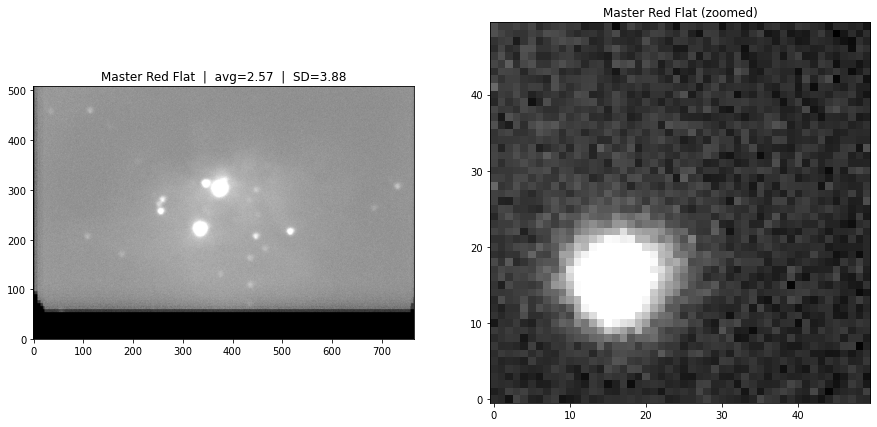

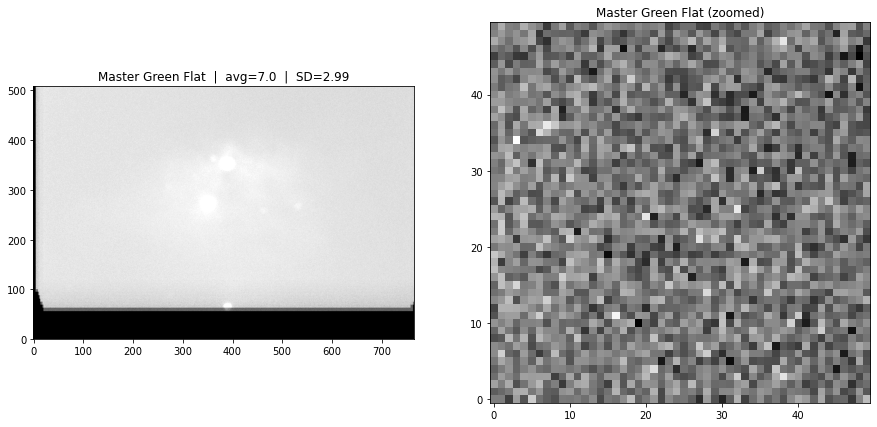

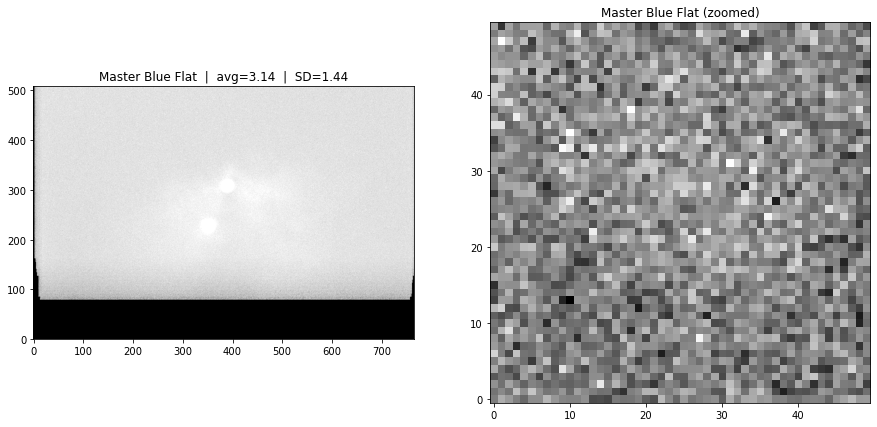

In [46]:
# Plot the median images

for im, cstr in zip([mast_sci_r, mast_sci_g, mast_sci_b], ['Red', 'Green', 'Blue']):
    
    plt_v1(im, 
           t1='Master ' + cstr + ' Flat', 
           t2='Master ' + cstr + ' Flat (zoomed)', 
           cmap='gray', #cstr + 's'
           rescale_img_q=True
          )

In [47]:
# Make copies of the master imgs
mast_sci_r_filt = np.copy(mast_sci_r)
mast_sci_g_filt = np.copy(mast_sci_g)
mast_sci_b_filt = np.copy(mast_sci_b)

# Align images (color channels)

In [48]:
mast_sci_r_filt_ali, dx, dy = align_two_imgs(mast_sci_r_filt, mast_sci_r_filt)

print('Red XY offsets = ', dx, dy)
#print(res)

mast_sci_g_filt_ali, dx, dy = align_two_imgs(mast_sci_r_filt, mast_sci_g_filt)

print('Green XY offsets = ', dx, dy)
#print(res)

mast_sci_b_filt_ali, dx, dy = align_two_imgs(mast_sci_r_filt, mast_sci_b_filt)

print('Blue XY offsets = ', dx, dy)
#print(res)

Red XY offsets =  0.0 0.0
Green XY offsets =  -15.34 -50.4
Blue XY offsets =  -16.24 -6.8


In [49]:
# Combine the color channels
fimg0 = combo_cc(mast_sci_r_filt_ali, mast_sci_g_filt_ali, mast_sci_b_filt_ali)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


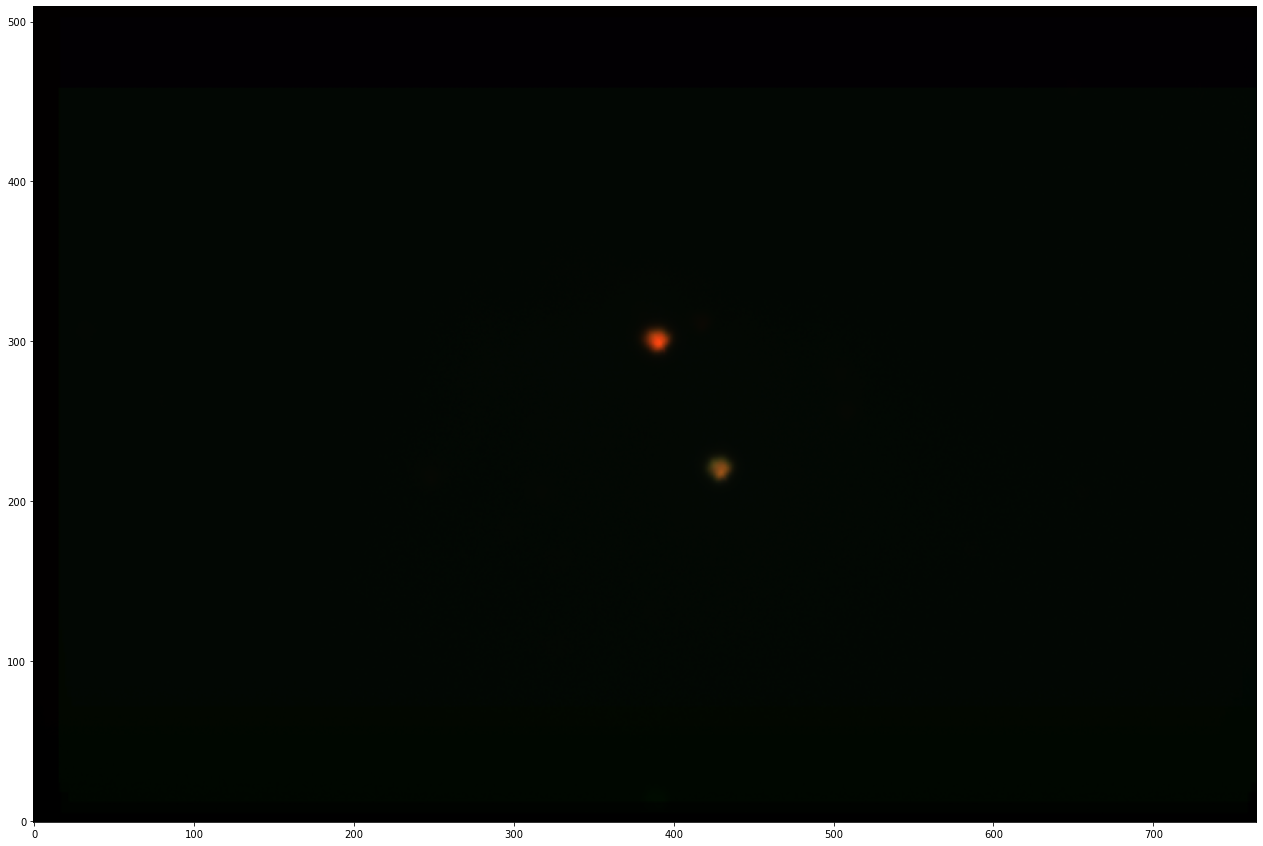

In [50]:
plt.figure(figsize=(25,15))
plt.imshow(np.fliplr(fimg0), origin='bottom')

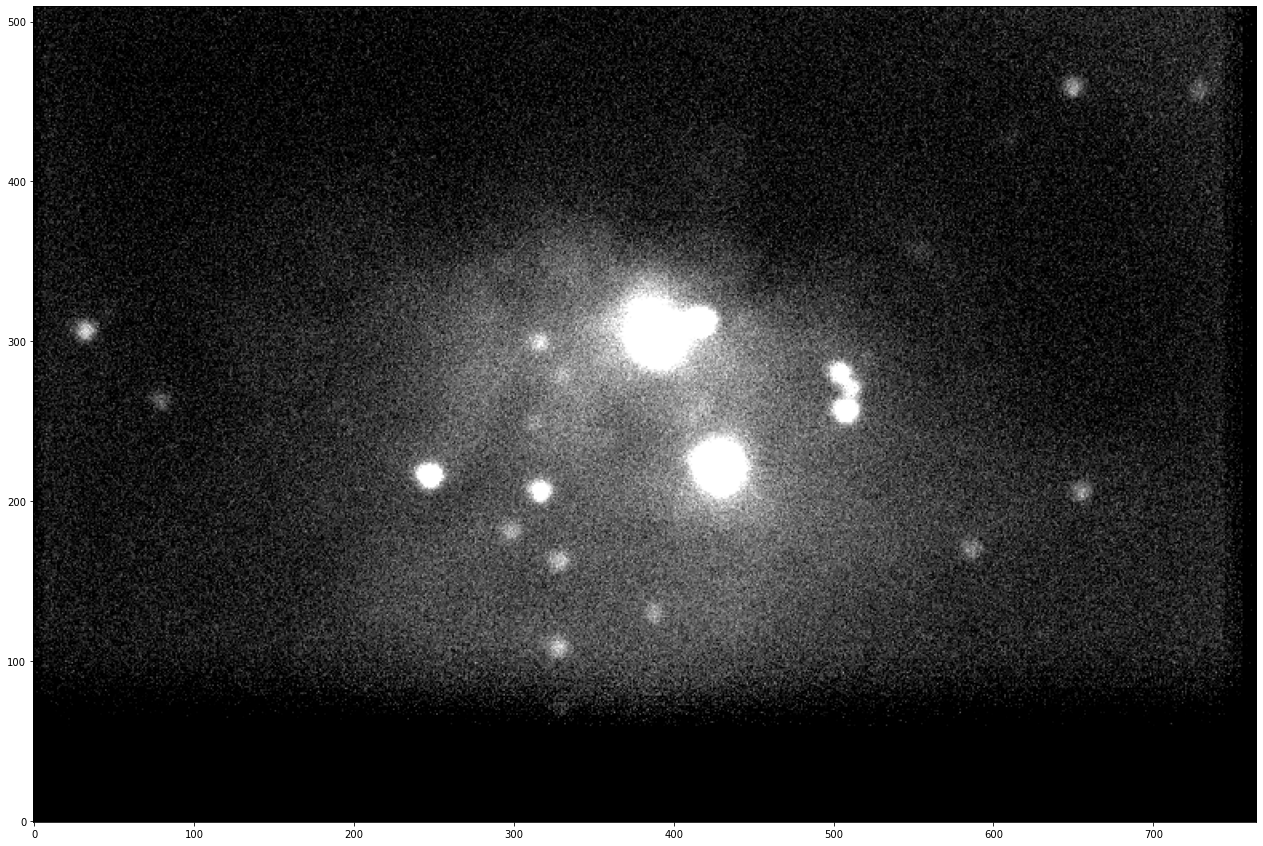

In [51]:
fimgrs = rs2(fimg0, 0, 30.01, 99.1)

plt.figure(figsize=(25,15))
plt.imshow(np.fliplr( fimgrs ), origin='bottom')